<a href="https://colab.research.google.com/github/albope/master-data-analytics-content/blob/master/EJERCICIO_2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

TensorFlow 2.x selected.


In [0]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

/tensorflow-2.1.0/python3.6/pkg_resources/py2_warn.py:22: UserWarning: Setuptools will stop working on Python 2
************************************************************
You are running Setuptools on Python 2, which is no longer
supported and
>>> SETUPTOOLS WILL STOP WORKING <<<
in a subsequent release (no sooner than 2020-04-20).
Please ensure you are installing
Setuptools using pip 9.x or later or pin to `setuptools<45`
in your environment.
If you have done those things and are still encountering
this message, please comment in
https://github.com/pypa/setuptools/issues/1458
about the steps that led to this unsupported combination.
************************************************************
  sys.version_info < (3,) and warnings.warn(pre + "*" * 60 + msg + "*" * 60)
Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 69.8MB/s]


In [0]:
df = pd.read_csv('london_bike_sharing.csv',parse_dates=[0], index_col=0)
df.shape

(17414, 9)

In [0]:
df.head(10)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0


In [0]:

df.shape

(17414, 9)

In [0]:
# First we want to normilize our data #con funciones de activacion no lineales hay que NORMALIZAR los datos de ENTRADA
TRAIN_SPLIT = 13931
dataset = df.values
multi_train_mean = dataset[0:TRAIN_SPLIT].mean(axis=0) #Aqui le decimos que tiene que actuar la media de cada columna si pusieras axis=1 aplicaria la formula a nivel de FILA!
multi_train_std = dataset[0:TRAIN_SPLIT].std(axis=0)
dataset = ( dataset - multi_train_mean) / multi_train_std

In [0]:
dataset

array([[-0.88498302, -1.71501557, -1.43191745, ..., -0.14529187,
         1.58233139,  1.41951953],
       [-0.92596423, -1.71501557, -1.35557796, ..., -0.14529187,
         1.58233139,  1.41951953],
       [-0.9296898 , -1.80656973, -1.35557796, ..., -0.14529187,
         1.58233139,  1.41951953],
       ...,
       [-0.74061736, -1.25724477, -1.50825693, ..., -0.14529187,
        -0.63197887,  1.41951953],
       [-0.84586458, -1.25724477, -1.50825693, ..., -0.14529187,
        -0.63197887,  1.41951953],
       [-0.92503284, -1.34879893, -1.58459642, ..., -0.14529187,
        -0.63197887,  1.41951953]])

In [0]:
# Arranging data to get training and labels 
def multivariate_data(dataset, start_index, end_index, 
                      history_size, target_size, single_step=False):
  data=[]
  labels=[]
  if end_index is None:
    end_index= len(dataset)-target_size
  start_index = start_index + history_size
  for i in range(start_index, end_index):
    sample = dataset[i-history_size:i]
    data.append(sample)
    if single_step:
      labels.append(dataset[i+target_size,0])
    else:
      labels.append(dataset[i:i+target_size,0])

  return np.array(data), np.array(labels)

In [0]:
# How many days we want show and how many to predict
past_history = 30
future_target = 30
multi_train_x, multi_train_y = multivariate_data(dataset, 0, TRAIN_SPLIT, 
                                                  past_history, future_target, 
                                                  single_step=False)
multi_val_x, multi_val_y =  multivariate_data(dataset, TRAIN_SPLIT, None, 
                                                  past_history, future_target, 
                                                  single_step=False)


In [0]:
multi_train_x.shape

(13901, 30, 9)

In [0]:
# Tensorflow Data Creation
BATCH_SIZE=200
BUFFER_SIZE=500
train_data_multi = tf.data.Dataset.from_tensor_slices((multi_train_x, multi_train_y))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((multi_val_x, multi_val_y))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
multivariate_model = tf.keras.models.Sequential([
                                                 tf.keras.layers.Bidirectional(
                                                 tf.keras.layers.LSTM(200, input_shape=multi_train_x.shape[-2:])),
                                                 tf.keras.layers.Dropout(rate=0.2),
                                                 tf.keras.layers.Dense(future_target)
                                                 ])


multivariate_model.compile(optimizer='adam', loss='MAE')

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo-',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro-',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

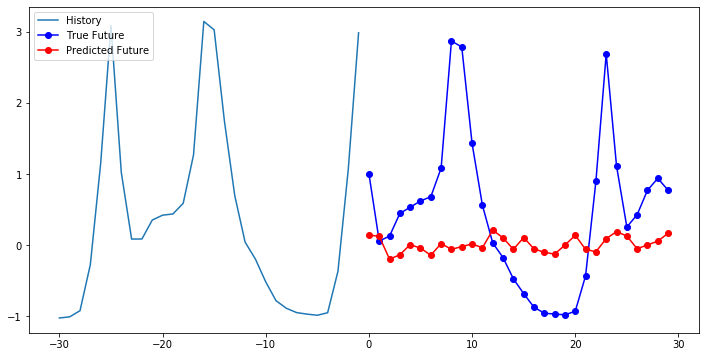

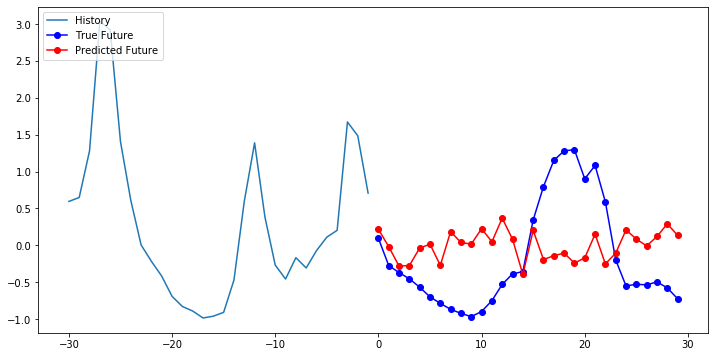

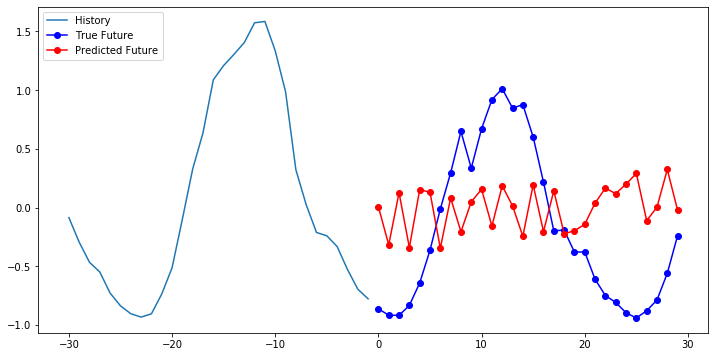

In [0]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multivariate_model.predict(x)[0])

In [0]:
EVALUATION_INTERVAL = len(multi_train_x)/ BATCH_SIZE
EPOCHS = 10

multivariate_model.fit(train_data_multi, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data_multi, validation_steps=20)

Train for 69.505 steps, validate for 20 steps
Epoch 1/10
70/69 [==============================] - 28s 402ms/step - loss: 0.5847 - val_loss: 0.4956
Epoch 2/10
70/69 [==============================] - 25s 363ms/step - loss: 0.4755 - val_loss: 0.4608
Epoch 3/10
70/69 [==============================] - 25s 364ms/step - loss: 0.4333 - val_loss: 0.4229
Epoch 4/10
70/69 [==============================] - 25s 364ms/step - loss: 0.3941 - val_loss: 0.3883
Epoch 5/10
70/69 [==============================] - 26s 365ms/step - loss: 0.3617 - val_loss: 0.3632
Epoch 6/10
70/69 [==============================] - 26s 366ms/step - loss: 0.3398 - val_loss: 0.3480
Epoch 7/10
70/69 [==============================] - 26s 365ms/step - loss: 0.3240 - val_loss: 0.3368
Epoch 8/10
70/69 [==============================] - 26s 366ms/step - loss: 0.3144 - val_loss: 0.3320
Epoch 9/10
70/69 [==============================] - 25s 364ms/step - loss: 0.3031 - val_loss: 0.3262
Epoch 10/10
70/69 [==========================

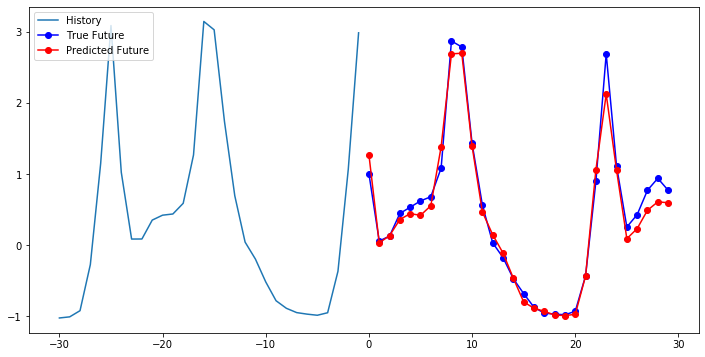

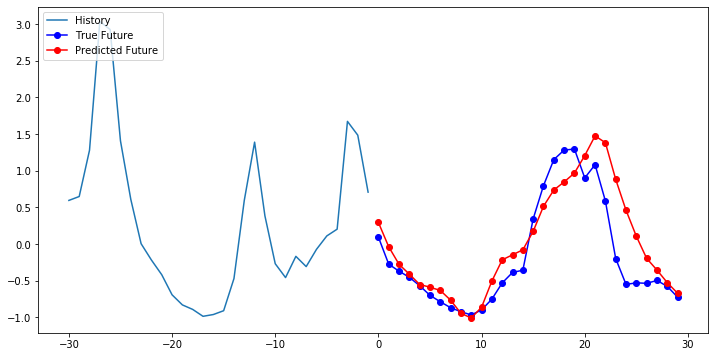

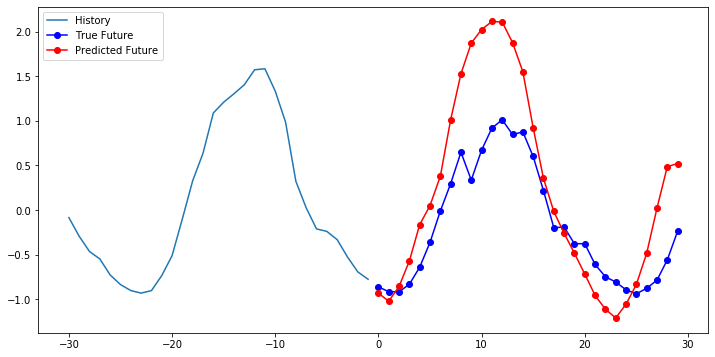

In [0]:
# Plot 3 examples of the validation test
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multivariate_model.predict(x)[0])